# Week 1 Project: Market Data Pipeline with Quality Checks

## 🎯 Learning Objectives
- Build a production-ready data pipeline
- Implement comprehensive data quality checks
- Handle missing data and outliers professionally
- Create reusable data download utilities

## ⏱️ Time Allocation
| Section | Duration |
|---------|----------|
| Data Download Setup | 30 min |
| Quality Checks Implementation | 45 min |
| Storage & Logging | 30 min |
| Testing & Validation | 15 min |

In [1]:
# Production-Ready Market Data Pipeline
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import logging

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("="*70)
print("WEEK 1 PROJECT: MARKET DATA PIPELINE WITH QUALITY CHECKS")
print("="*70)

WEEK 1 PROJECT: MARKET DATA PIPELINE WITH QUALITY CHECKS


## 1. Data Download Class

Professional data pipelines use classes with error handling, logging, and retry logic.

In [2]:
class MarketDataDownloader:
    """Production-ready market data downloader with validation."""
    
    def __init__(self, tickers, start_date=None, end_date=None):
        self.tickers = tickers if isinstance(tickers, list) else [tickers]
        self.end_date = end_date or datetime.now()
        self.start_date = start_date or (self.end_date - timedelta(days=5*365))
        self.raw_data = None
        self.clean_data = None
        
    def download(self):
        """Download data with error handling."""
        logger.info(f"Downloading data for {self.tickers}")
        try:
            self.raw_data = yf.download(
                self.tickers, 
                start=self.start_date, 
                end=self.end_date,
                progress=False,
                auto_adjust=True
            )
            logger.info(f"Downloaded {len(self.raw_data)} rows")
            return self.raw_data
        except Exception as e:
            logger.error(f"Download failed: {e}")
            raise
    
    def get_prices(self):
        """Extract close prices."""
        if self.raw_data is None:
            self.download()
        if len(self.tickers) == 1:
            return self.raw_data['Close'].to_frame(self.tickers[0])
        return self.raw_data['Close']

# Download data
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
downloader = MarketDataDownloader(TICKERS)
prices = downloader.get_prices()
print(f"\n✅ Downloaded {len(prices)} days of data for {len(TICKERS)} stocks")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")

2026-01-24 12:10:01,603 - INFO - Downloading data for ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
2026-01-24 12:10:02,458 - INFO - Downloaded 1256 rows



✅ Downloaded 1256 days of data for 5 stocks
Date range: 2021-01-25 to 2026-01-23


## 2. Data Quality Checks

### Why Quality Checks Matter
- **Missing data** can cause model failures
- **Outliers** may be errors or real events (need to distinguish)
- **Corporate actions** (splits, dividends) can corrupt returns

In [3]:
class DataQualityChecker:
    """Comprehensive data quality validation."""
    
    def __init__(self, data):
        self.data = data
        self.issues = []
        
    def check_missing_values(self):
        """Check for missing values."""
        missing = self.data.isnull().sum()
        missing_pct = (missing / len(self.data) * 100).round(2)
        
        print("\n📊 MISSING VALUE CHECK")
        print("-" * 40)
        for col in self.data.columns:
            status = "✅" if missing[col] == 0 else "⚠️"
            print(f"{status} {col}: {missing[col]} ({missing_pct[col]}%)")
        
        if missing.sum() > 0:
            self.issues.append(f"Missing values found: {missing.sum()} total")
        return missing
    
    def check_outliers(self, threshold=5):
        """Detect outliers using Z-score."""
        returns = self.data.pct_change().dropna()
        z_scores = (returns - returns.mean()) / returns.std()
        outliers = (np.abs(z_scores) > threshold).sum()
        
        print(f"\n📊 OUTLIER CHECK (Z-score > {threshold})")
        print("-" * 40)
        for col in outliers.index:
            status = "✅" if outliers[col] == 0 else "⚠️"
            print(f"{status} {col}: {outliers[col]} outliers")
        
        return outliers
    
    def check_price_jumps(self, threshold=0.20):
        """Detect suspicious price jumps (potential splits/errors)."""
        returns = self.data.pct_change().dropna()
        jumps = (np.abs(returns) > threshold).sum()
        
        print(f"\n📊 PRICE JUMP CHECK (|return| > {threshold*100}%)")
        print("-" * 40)
        for col in jumps.index:
            status = "✅" if jumps[col] == 0 else "⚠️"
            print(f"{status} {col}: {jumps[col]} large moves")
        
        return jumps
    
    def run_all_checks(self):
        """Run all quality checks."""
        print("="*60)
        print("DATA QUALITY REPORT")
        print("="*60)
        
        self.check_missing_values()
        self.check_outliers()
        self.check_price_jumps()
        
        print("\n" + "="*60)
        if len(self.issues) == 0:
            print("✅ ALL QUALITY CHECKS PASSED")
        else:
            print(f"⚠️ {len(self.issues)} ISSUES FOUND")
            for issue in self.issues:
                print(f"   - {issue}")
        print("="*60)

# Run quality checks
checker = DataQualityChecker(prices)
checker.run_all_checks()

DATA QUALITY REPORT

📊 MISSING VALUE CHECK
----------------------------------------
✅ AAPL: 0 (0.0%)
✅ GOOGL: 0 (0.0%)
✅ GS: 0 (0.0%)
✅ JPM: 0 (0.0%)
✅ MSFT: 0 (0.0%)

📊 OUTLIER CHECK (Z-score > 5)
----------------------------------------
⚠️ AAPL: 3 outliers
⚠️ GOOGL: 1 outliers
⚠️ GS: 3 outliers
⚠️ JPM: 2 outliers
⚠️ MSFT: 2 outliers

📊 PRICE JUMP CHECK (|return| > 20.0%)
----------------------------------------
✅ AAPL: 0 large moves
✅ GOOGL: 0 large moves
✅ GS: 0 large moves
✅ JPM: 0 large moves
✅ MSFT: 0 large moves

✅ ALL QUALITY CHECKS PASSED


## 3. Data Cleaning & Imputation

In [4]:
class DataCleaner:
    """Clean and impute financial data."""
    
    def __init__(self, data):
        self.data = data.copy()
        
    def fill_missing(self, method='ffill'):
        """Fill missing values with forward fill."""
        before = self.data.isnull().sum().sum()
        self.data = self.data.fillna(method=method)
        after = self.data.isnull().sum().sum()
        print(f"✅ Filled {before - after} missing values using {method}")
        return self
    
    def winsorize_returns(self, lower=0.01, upper=0.99):
        """Winsorize extreme returns."""
        returns = self.data.pct_change()
        for col in returns.columns:
            lower_bound = returns[col].quantile(lower)
            upper_bound = returns[col].quantile(upper)
            returns[col] = returns[col].clip(lower_bound, upper_bound)
        print(f"✅ Winsorized returns at [{lower*100}%, {upper*100}%] percentiles")
        return returns
    
    def get_clean_data(self):
        return self.data

# Clean data
cleaner = DataCleaner(prices)
cleaner.fill_missing()
clean_prices = cleaner.get_clean_data()
returns = cleaner.winsorize_returns()
returns = returns.dropna()

print(f"\n📊 Clean data: {len(clean_prices)} days")

✅ Filled 0 missing values using ffill
✅ Winsorized returns at [1.0%, 99.0%] percentiles

📊 Clean data: 1256 days


## 4. Data Visualization

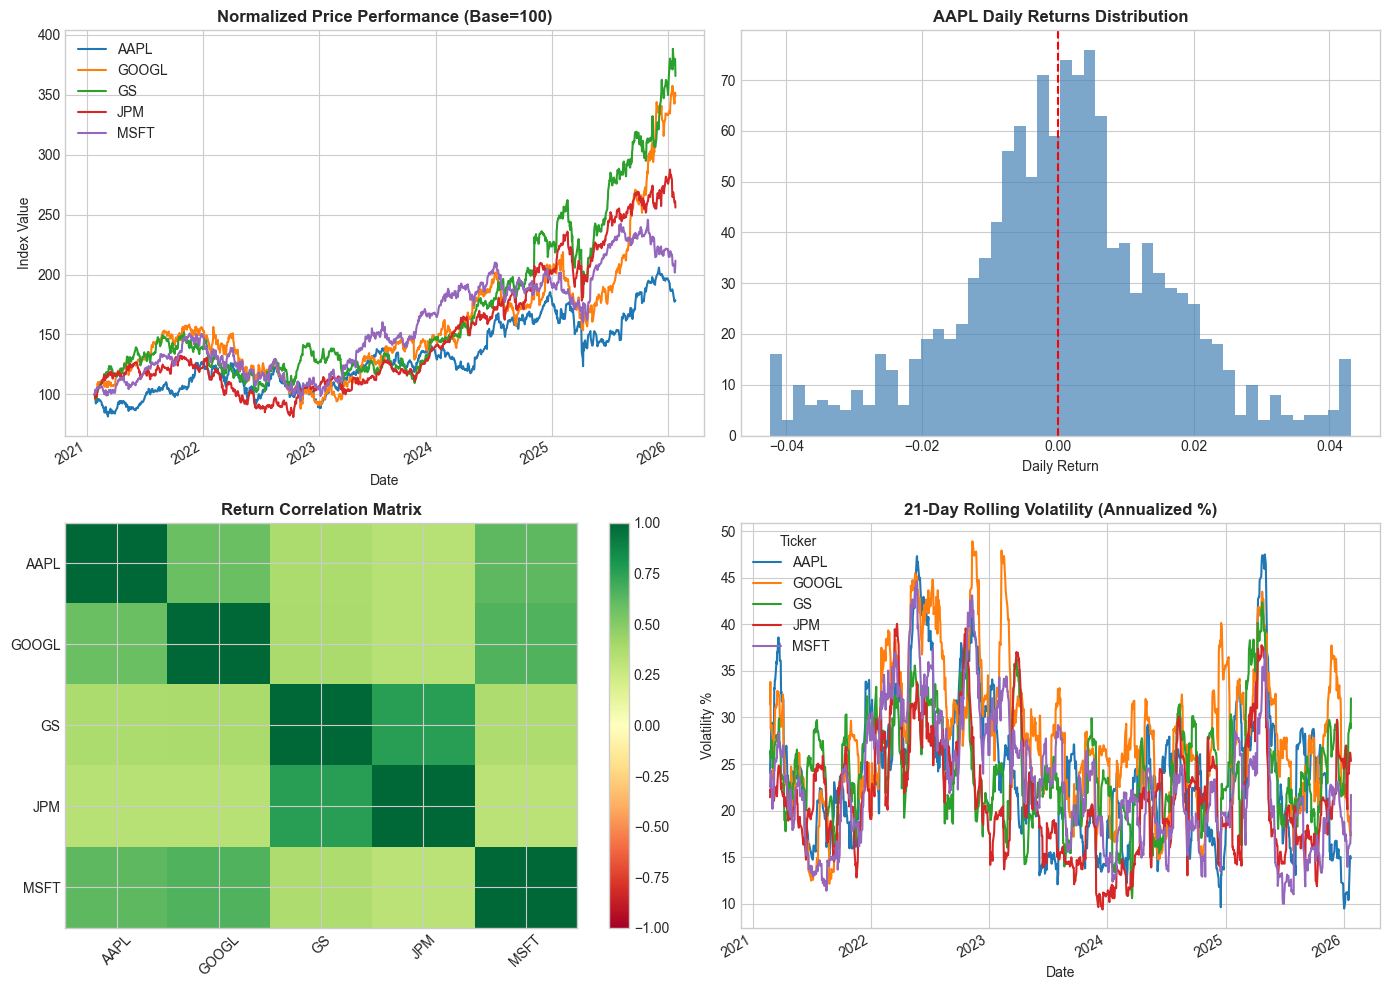


✅ Data pipeline complete and validated!


In [5]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price chart (normalized)
ax1 = axes[0, 0]
normalized = clean_prices / clean_prices.iloc[0] * 100
normalized.plot(ax=ax1)
ax1.set_title('Normalized Price Performance (Base=100)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Index Value')
ax1.legend(loc='upper left')

# Returns distribution
ax2 = axes[0, 1]
returns['AAPL'].hist(bins=50, ax=ax2, alpha=0.7, color='steelblue')
ax2.set_title('AAPL Daily Returns Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Daily Return')
ax2.axvline(0, color='red', linestyle='--')

# Correlation heatmap
ax3 = axes[1, 0]
corr = returns.corr()
im = ax3.imshow(corr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax3.set_xticks(range(len(corr.columns)))
ax3.set_yticks(range(len(corr.columns)))
ax3.set_xticklabels(corr.columns, rotation=45)
ax3.set_yticklabels(corr.columns)
ax3.set_title('Return Correlation Matrix', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax3)

# Rolling volatility
ax4 = axes[1, 1]
rolling_vol = returns.rolling(21).std() * np.sqrt(252) * 100
rolling_vol.plot(ax=ax4)
ax4.set_title('21-Day Rolling Volatility (Annualized %)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Volatility %')

plt.tight_layout()
plt.show()

print("\n✅ Data pipeline complete and validated!")

## 5. Summary Statistics

In [6]:
# Generate summary statistics
def generate_summary_stats(returns):
    """Generate comprehensive summary statistics."""
    stats = pd.DataFrame()
    stats['Annual Return %'] = (returns.mean() * 252 * 100).round(2)
    stats['Annual Vol %'] = (returns.std() * np.sqrt(252) * 100).round(2)
    stats['Sharpe Ratio'] = (stats['Annual Return %'] / stats['Annual Vol %']).round(2)
    stats['Max Drawdown %'] = ((returns.cumsum() - returns.cumsum().cummax()).min() * 100).round(2)
    stats['Skewness'] = returns.skew().round(2)
    stats['Kurtosis'] = returns.kurtosis().round(2)
    return stats

summary = generate_summary_stats(returns)
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(summary.to_string())
print("="*70)


SUMMARY STATISTICS
        Annual Return %  Annual Vol %  Sharpe Ratio  Max Drawdown %  Skewness  Kurtosis
Ticker                                                                                 
AAPL              12.59         25.28          0.50          -36.03     -0.12      0.57
GOOGL             29.58         28.85          1.03          -48.79      0.03      0.67
GS                28.90         25.18          1.15          -33.23     -0.01      0.39
JPM               20.17         22.45          0.90          -46.71     -0.28      0.87
MSFT              15.97         24.01          0.67          -38.33     -0.10      0.46


## 🎯 Key Takeaways

1. **Always validate data** before using in models
2. **Log everything** for debugging and auditing
3. **Handle edge cases** (missing data, outliers, corporate actions)
4. **Use classes** for reusable, testable code
5. **Document your pipeline** for team collaboration

## 📚 Interview Questions

1. How do you handle missing data in financial time series?
2. What's the difference between forward fill and interpolation?
3. How do you detect and handle stock splits in historical data?
4. What quality checks would you run before training a model?